# Data cleaning - Extreme cases

In this notebook, we detail how some data processing techniques are implemented in order to identify noisy trajectories. The focus of this procedure is detecting extreme cases in trajectories where there is a huge "jump" either at the beggining or at the end of a trajectory. Once these jumps are detected, the trajectory is trimmed for further analysis.

By extreme case, we mean differences between points that are longer than the `distance_total` attribute of trajectories. When these jumps occur either at the begin or the end of a trajectory, we trim the trajectory.

In [1]:
import os
import sys
sys.path.insert(0, os.path.pardir)

from database import db
from database.models import Workout, User
from database import preprocessing as pp

In [2]:
import warnings
import ipympl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import numpy as np
import pandas as pd
from pprint import pprint
from shapely import wkt, wkb
from geoalchemy2 import Geography
from geopy.distance import vincenty

In [3]:
%matplotlib ipympl
warnings.filterwarnings('ignore')

In [4]:
def mad(x):
    return 1.483 * np.median(np.abs(x - np.median(x)))

def modified_zscore(x):
    return 0.6745 * (x - np.median(x)) / mad(x)

def get_outliers(series, threshold=3.5):
    mz = modified_zscore(series)
    low_outliers = [i for i, mz in enumerate(mz) if mz < -threshold]
    high_outliers = [i for i, mz in enumerate(mz) if mz > threshold]

    return (low_outliers, high_outliers)

In [5]:
session = db.connect_db()

We query workouts ordered by the difference between `calculated_length` and `distance_total` (`diff_length` column):

In [6]:
#df.to_csv('long2.csv')

In [7]:
#plt.figure()
#sns.distplot(df['diff_length'], rug=False);

In [46]:
long_workouts = session.query(Workout).filter(Workout.calculated_length>42_000).all()

In [47]:
len(long_workouts)

221

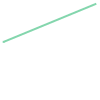

In [34]:
#93763762
#97450456

workout = session.query(Workout).filter_by(id=563373953).first()
raw_trajectory = wkt.loads(session.scalar(workout.raw_trajectory.ST_AsText()))
trajectory = pp.remove_redundant_points(str(raw_trajectory))
raw_trajectory

In [35]:
#str(trajectory)

In [36]:
lens = []
for point, next_point in zip(trajectory.coords, trajectory.coords[1:]):
    dist = vincenty((point[1], point[0]), (next_point[1], next_point[0])).meters
    lens.append(dist)

len(lens), sum(lens)

(3067, 9679709.676991018)

3067 9679708.675757032


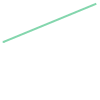

In [37]:
# remove redundant points in the trajectory (zero length between points)
new_coords = []
discarded = []
for point, dist in zip(trajectory.coords, lens):
    if dist != 0:
        new_coords.append(point)
    else:
        #print(trajectory.coords[i], trajectory.coords[i-1], lens[i], lens[i-1], lens[i+1])
        discarded.append(dist)

wkt_coords = [f'{c[0]} {c[1]}' for c in new_coords]
middle_wtk = ', '.join(wkt_coords)
wkt_str = f'LINESTRING({middle_wtk})'
trajectory = wkt.loads(wkt_str)

lens = [-1]
for point, next_point in zip(trajectory.coords, trajectory.coords[1:]):
    dist = vincenty((point[1], point[0]), (next_point[1], next_point[0])).meters
    lens.append(dist)

print(len(trajectory.coords), sum(lens))
trajectory

### method 1 - jumps longer than the trajectory itself

In [38]:
# 1 - identify 
long_distances_index = [i for i, l in enumerate(lens) if l > workout.mmf_distance]
outlier_distances = [lens[i] for i in long_distances_index]

outlier_positions = [i/len(lens) for i in long_distances_index]
distance_to_end = [len(lens) - i for i in long_distances_index]

print(len(lens))
pprint(outlier_distances)
pprint(outlier_positions)

near_start = [long_distances_index[i] for i, out in enumerate(outlier_positions) if out <= 0.1]
near_end = [long_distances_index[i] for i, out in enumerate(outlier_positions) if out >= 0.9]
print('near_start', near_start)
print('near_end', near_end)

3067
[9671711.767764907]
[0.9996739484838605]
near_start []
near_end [3066]


0 3066


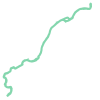

In [39]:
# rebuild trimmed trajectory 
start, end = 0, len(lens)
new_trajectory = trajectory

if near_start:
    start = max(near_start)+1
if near_end:
    end = min(near_end)

print(start, end)

if outlier_positions:
    wkt_coords = [f'{c[0]} {c[1]}' for c in trajectory.coords[start:end]]
    middle_wtk = ', '.join(wkt_coords)
    wkt_str = f'LINESTRING({middle_wtk})'
    new_trajectory = wkt.loads(wkt_str)

new_trajectory

In [20]:
new_length = sum(lens[start:end])
new_diff = workout.mmf_distance - new_length
print('distance\t', workout.mmf_distance)
print('new len \t', new_length)
print('new diff\t', new_diff)
print('prev diff\t', workout.diff_length)

distance	 1748.2
new len 	 1690.341188789147
new diff	 57.85881121085299
prev diff	 -5314921.0


### method 2 - Outlier Labeling Rule

In [ ]:
#lens = [l for l in lens if l != 0]

_, outliers = get_outliers(lens)
outlier_positions = [i/len(lens) for i in outliers]
outlier_distances = [lens[i] for i in outliers]

pprint((list(zip(outlier_positions, outlier_distances))))

near_start = [outliers[i] for i, out in enumerate(outlier_positions) if out <= 0.1 and outlier_distances[i] > 50]
near_end = [outliers[i] for i, out in enumerate(outlier_positions) if out >= 0.9 and outlier_distances[i] > 50]
print('near_start', near_start)
print('near_end', near_end)

In [ ]:
# rebuild trimmed trajectory 
start, end = 0, len(lens)
new_trajectory = trajectory

if near_start:
    start = max(near_start)+1
if near_end:
    end = min(near_end)

print(start, end)

if outlier_positions:
    wkt_coords = [f'{c[0]} {c[1]}' for c in trajectory.coords[start:end]]
    middle_wtk = ', '.join(wkt_coords)
    wkt_str = f'LINESTRING({middle_wtk})'
    new_trajectory = wkt.loads(wkt_str)

new_trajectory

In [ ]:
new_length = sum(lens[start:end])
new_diff = workout.mmf_distance - new_length
print('distance\t', workout.mmf_distance)
print('new len \t', new_length)
print('new diff\t', new_diff)
print('prev diff\t', workout.diff_length)

## method 3 - contributions

In [ ]:
length_withouth_ith = [sum(lens[0:i])+sum(lens[i+1:len(lens)]) for i in range(len(lens))]
contribution = [1-(l/sum(lens)) for l in length_withouth_ith]
#pprint(list(zip(contribution, lens)))
print(['{0:.6f}'.format(c) for c in contribution])
i_outliers = [i-1 for i, c in enumerate(contribution) if c > 0.01]
i_outliers

In [ ]:
# remove outliers from trajectory
new_coords = [coord for i, coord in enumerate(trajectory.coords) if i not in i_outliers]
print('len={}'.format(len(new_coords)))
wkt_coords = [f'{c[0]} {c[1]} {c[2]}' for c in new_coords]
middle_wtk2 = ', '.join(wkt_coords)
wkt_str2 = f'LINESTRING({middle_wtk2})'
new_trajectory2 = wkt.loads(wkt_str2)

new_trajectory2

In [ ]:
new_length = sum([l for i, l in enumerate(lens) if i not in i_outliers])
new_diff = workout.mmf_distance - new_length
print('distance\t', workout.mmf_distance)
print('new len \t', new_length)
print('new diff\t', new_diff)
print('prev diff\t', workout.diff_length)

import re
from datetime import datetime, timedelta
ewkt = session.scalar(workout.trajectory.ST_AsEWKT())
matches = re.findall('(\d+(,|\)))', ewkt)
matches = [match[0][:len(match[0])-1] for match in matches]
timestamps = [datetime.fromtimestamp(int(ts)) for ts in matches]

time_diff = [0] + [(t2 - t1).seconds for t1, t2 in zip(timestamps, timestamps[1:])]
print(time_diff[:30])
print(time_diff[len(time_diff)-30:])

plt.figure()
plt.plot(lens, 'o-');
#plt.plot(time_diff);

plt.figure()
plt.plot(time_diff);